In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import torch
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

import flippers

In [3]:
# This helper loads any dataset in the wrench benchmarks
# and creates monopolar label matrices from their multipolar data
def load_wrench_dataset(dataset):
    dataset = "datasets/" + f"{dataset}" + "/{}.json"
    train = pd.read_json(dataset.format("train")).T
    dev = pd.read_json(dataset.format("valid")).T
    test = pd.read_json(dataset.format("test")).T

    L_train, polarities, polarities_mapping = flippers.multipolar_to_monopolar(
        train["weak_labels"].apply(pd.Series)
    )
    L_dev, _, _ = flippers.multipolar_to_monopolar(
        dev["weak_labels"].apply(pd.Series), polarities_mapping
    )
    L_test, _, _ = flippers.multipolar_to_monopolar(
        test["weak_labels"].apply(pd.Series), polarities_mapping
    )

    return (train, dev, test), (L_train, L_dev, L_test), polarities

Choose your dataset here

In [4]:
datasets = ["cdr", "yelp", "youtube", "census", "spouse", "basketball", "sms", "tennis"]
dataset = "youtube"

data, weak_labels, polarities = load_wrench_dataset(dataset)
train, dev, test = data
L_train, L_dev, L_test = weak_labels

C:\Users\liamt\Repos\flippers\flippers\_core\_core.py:132: UserWarning: Polarity mapping if not furnished.
Make sure L captures all possible values of each weak labelers.
  warnings.warn(


In [5]:
class_balances = list(
    dev["label"].astype(int).value_counts(normalize=True).sort_index()
)
class_balances

[0.5333333333333333, 0.4666666666666667]

In [6]:
L_train0, L_test0 = L_train.copy(), L_test.copy()

In [7]:
text = pd.DataFrame.from_dict(train["data"].tolist())

In [8]:
sentences = list(text["text"])

In [9]:
def preprocess_text(sentences):
    # Remove Nones for sentences
    sentences = ["None" if doc is None else doc for doc in sentences]

    import re

    for i, sentence in enumerate(sentences):
        sentences[i] = sentences[i].replace("\ufeff", "")

    # Define regular expression pattern for links
    link_pattern = re.compile(r"http\S+")

    # Replace links with 'http' in each sentence
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(link_pattern, "http", sentence)

    # Define regular expression pattern for emojis
    emoji_pattern = re.compile("[" "\U0001F600-\U0001F64F" "]+", flags=re.UNICODE)

    # Replace emojis in each sentence
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(emoji_pattern, "emoji", sentence)

    # Define regular expression pattern for special characters and Unicode
    special_pattern = re.compile(r"[^a-zA-Z0-9\s.,:!?;]")

    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(special_pattern, " unicode ", sentence)

    # Punctuation
    punctuation = re.compile(r"[^\w\s]|_")

    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(punctuation, " ", sentence)

    # Small words
    small_words = re.compile(r"\b\w{1,3}\b")
    for i, sentence in enumerate(sentences):
        sentences[i] = re.sub(small_words, " ", sentence)

    stop_words = [
        "ourselves",
        "hers",
        "between",
        "yourself",
        "but",
        "again",
        "there",
        "about",
        "once",
        "during",
        "out",
        "very",
        "having",
        "with",
        "they",
        "own",
        "an",
        "be",
        "some",
        "for",
        "do",
        "its",
        "yours",
        "such",
        "into",
        "of",
        "most",
        "itself",
        "other",
        "off",
        "is",
        "s",
        "am",
        "or",
        "who",
        "as",
        "from",
        "him",
        "each",
        "the",
        "themselves",
        "until",
        "below",
        "are",
        "we",
        "these",
        "your",
        "his",
        "through",
        "don",
        "nor",
        "me",
        "were",
        "her",
        "more",
        "himself",
        "this",
        "down",
        "should",
        "our",
        "their",
        "while",
        "above",
        "both",
        "up",
        "to",
        "ours",
        "had",
        "she",
        "all",
        "no",
        "when",
        "at",
        "any",
        "before",
        "them",
        "same",
        "and",
        "been",
        "have",
        "in",
        "will",
        "on",
        "does",
        "yourselves",
        "then",
        "that",
        "because",
        "what",
        "over",
        "why",
        "so",
        "can",
        "did",
        "not",
        "now",
        "under",
        "he",
        "you",
        "herself",
        "has",
        "just",
        "where",
        "too",
        "only",
        "myself",
        "which",
        "those",
        "i",
        "after",
        "few",
        "whom",
        "t",
        "being",
        "if",
        "theirs",
        "my",
        "against",
        "a",
        "by",
        "doing",
        "it",
        "how",
        "further",
        "was",
        "here",
        "than",
    ]

    # Tokenize
    tokenized_docs = [doc.lower().split() for doc in sentences]

    # Remove stop words
    tokenized_docs = [
        [word for word in doc if word not in stop_words] for doc in tokenized_docs
    ]

    # Create a dictionary from the tokenized sentences
    dictionary = Dictionary(tokenized_docs)

    # Create a bag of words (BoW) representation for each document
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    return corpus, dictionary

In [10]:
corpus, dictionary = preprocess_text(sentences)

In [107]:
%%time
num_topics = 6
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=100,
    update_every=1,
    passes=10,
    alpha="auto",
    eta="auto",
    per_word_topics=False,
)

lda_model.print_topics()

CPU times: total: 4.34 s
Wall time: 5.16 s


[(0,
  '0.032*"best" + 0.031*"check" + 0.023*"playlist" + 0.023*"youtube" + 0.021*"2015" + 0.021*"like" + 0.020*"song" + 0.015*"watching" + 0.014*"ever" + 0.014*"please"'),
 (1,
  '0.055*"check" + 0.049*"video" + 0.037*"youtube" + 0.029*"unicode" + 0.029*"http" + 0.017*"like" + 0.015*"views" + 0.012*"billion" + 0.011*"guys" + 0.009*"music"'),
 (2,
  '0.040*"please" + 0.034*"subscribe" + 0.030*"song" + 0.024*"unicode" + 0.023*"love" + 0.021*"like" + 0.020*"check" + 0.019*"channel" + 0.015*"guys" + 0.013*"videos"'),
 (3,
  '0.507*"unicode" + 0.012*"check" + 0.009*"http" + 0.009*"song" + 0.009*"video" + 0.009*"quot" + 0.007*"like" + 0.006*"subscribe" + 0.006*"youtube" + 0.005*"href"'),
 (4,
  '0.037*"channel" + 0.032*"check" + 0.029*"unicode" + 0.024*"subscribe" + 0.019*"please" + 0.011*"music" + 0.010*"like" + 0.010*"video" + 0.010*"views" + 0.008*"help"'),
 (5,
  '0.054*"katy" + 0.042*"perry" + 0.024*"song" + 0.020*"love" + 0.013*"million" + 0.013*"music" + 0.012*"megan" + 0.007*"video"

In [108]:
topics_polarities = np.array([0, 1, 1, 1, 1, 0])

In [109]:
def get_topics(df):
    text = pd.DataFrame.from_dict(df["data"].tolist())
    sentences = list(text["text"])
    corpus, _ = preprocess_text(sentences)
    # Get the topic distribution for each document in the corpus
    topic_probabilities = pd.DataFrame(
        [
            [x[1] for x in sentence]
            for sentence in lda_model.get_document_topics(corpus, minimum_probability=0)
        ]
    )
    topic = pd.DataFrame(topic_probabilities).values.argmax(axis=1)
    # Create a new dataframe with columns for all possible values
    L_topic = pd.DataFrame(columns=[f"topic_{i}" for i in range(num_topics)])
    # Set the values in each row based on the original column
    for i, t in enumerate(list(topic)):
        L_topic.loc[i, f"topic_{t}"] = 1
    L_topic = L_topic.fillna(0)
    return L_topic

In [110]:
get_topics(train)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5
0,0,0,1,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
1581,1,0,0,0,0,0
1582,0,0,1,0,0,0
1583,0,0,0,1,0,0
1584,0,0,0,0,1,0


In [111]:
L_train = pd.concat([L_train0, get_topics(train)], axis=1)
L_test = pd.concat([L_test0, get_topics(test)], axis=1)

In [112]:
from flippers.models import SnorkelModel

In [138]:
topics_polarities = np.ones(num_topics)
m = SnorkelModel(
    np.concatenate((polarities, topics_polarities), axis=0),
    class_balances=class_balances,
    cardinality=2,
)
m.fit(L_train, learning_rate=5e-4, balance_penalty=1e-3)

In [139]:
y_test = test["label"].astype(int).values

In [140]:
Metrics = {}


def score(
    model,
    L=L_test,
    y_true=y_test,
    boxplots=True,
    fill_proba=False,
    name="",
    predict_proba_args={},
):
    y_pred = model.predict_proba(L, *predict_proba_args)[:, 1]

    def fill_proba(proba):
        proba = proba.copy()
        proba[L.sum(axis=1) == 0] = class_balances[1]
        return proba

    if fill_proba:
        y_pred = fill_proba(y_pred)

    AP = metrics.average_precision_score(y_true, y_pred)
    F1 = metrics.f1_score(y_true, y_pred.round())
    AUC = metrics.roc_auc_score(y_true, y_pred)
    Accuracy = metrics.accuracy_score(y_true, y_pred.round())
    Balanced_Accuracy = metrics.balanced_accuracy_score(y_true, y_pred.round())
    M = {
        "F1": F1,
        "Average_Precision": AP,
        "AUC": AUC,
        "Accuracy": Accuracy,
        "Balanced_Accuracy": Balanced_Accuracy,
    }
    for key in M:
        M[key] = round(M[key], 3)

    if boxplots:
        fig, axs = plt.subplots(1, 2, figsize=(8, 3))
        plt.title(name)
        pd.DataFrame({"y_pred": y_pred, "y_true": y_true}).boxplot(
            by="y_true", ax=axs[0]
        )
        axs[0].set_title("Predicted probabilities grouped by ground truth")
        axs[0].set_ylim([0, 1])
        axs[0].get_figure().suptitle("")
        plt.ylabel("y_pred")

        pd.Series(y_pred).plot.box(ax=axs[1])
        axs[1].set_title("Predicted probabilties")
        axs[1].set_ylim([0, 1])
        axs[1].axhline(
            y_true.mean(), color="g", linestyle="--", alpha=0.3, label="Mean of y_true"
        )

        # Add a cross indicating the mean of y_pred
        mean_y_pred = pd.Series(y_pred).mean()
        axs[1].scatter(
            [1], [mean_y_pred], marker="+", color="r", s=200, label="Mean of y_pred"
        )
        axs[1].legend()

        plt.ylabel("y_pred")
        plt.tight_layout()
        plt.show()
    if name:
        global Metrics
        Metrics[name] = M
    return M

baseline f1 .817 accuracy .84

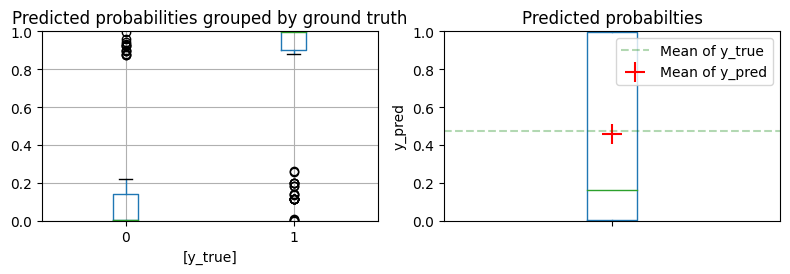

{'F1': 0.841,
 'Average_Precision': 0.929,
 'AUC': 0.928,
 'Accuracy': 0.856,
 'Balanced_Accuracy': 0.853}

In [141]:
# This is the Uniform Marginals calculation the Snorkel and Metal libraries use
# Performance should be very similar to the Snorkel model
score(m, name="flippers")

<Axes: >

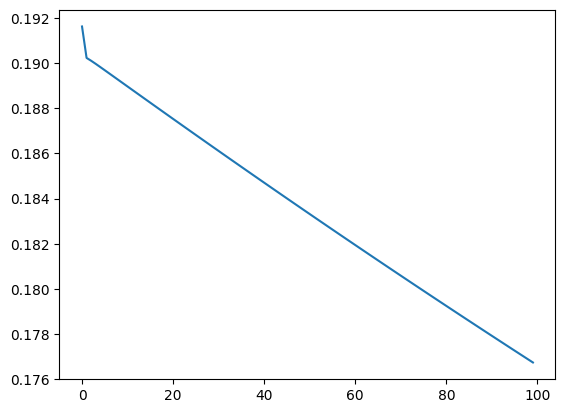

In [142]:
pd.Series(m.loss_history).plot()